[*********************100%***********************]  2 of 2 completed


  Company  Current Price  Trailing P/E  EPS (TTM)     Market Cap
0     AMD      99.510002     106.44000       1.00   172483887104
1    NVDA     120.138954      40.03401       2.94  2871879794688


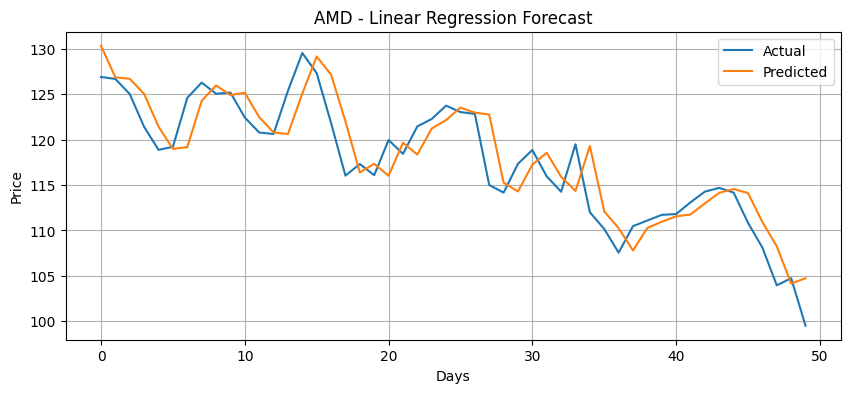

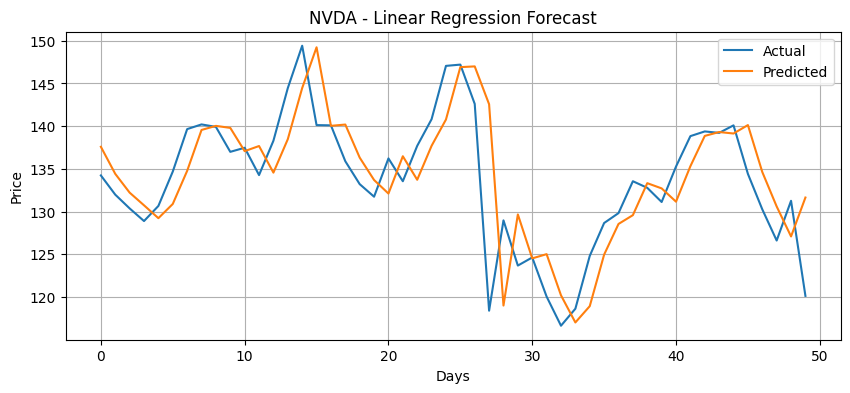

      Total Return (No Tax)  Number of Trades  Average Trade Return  \
AMD                2.839837              19.0              0.104181   
NVDA               7.468236              19.0              0.164558   

      Total Return (Taxed)  Number of Trades  Average Trade Return  
AMD               2.839254              19.0              0.104172  
NVDA              7.466949              19.0              0.164549  


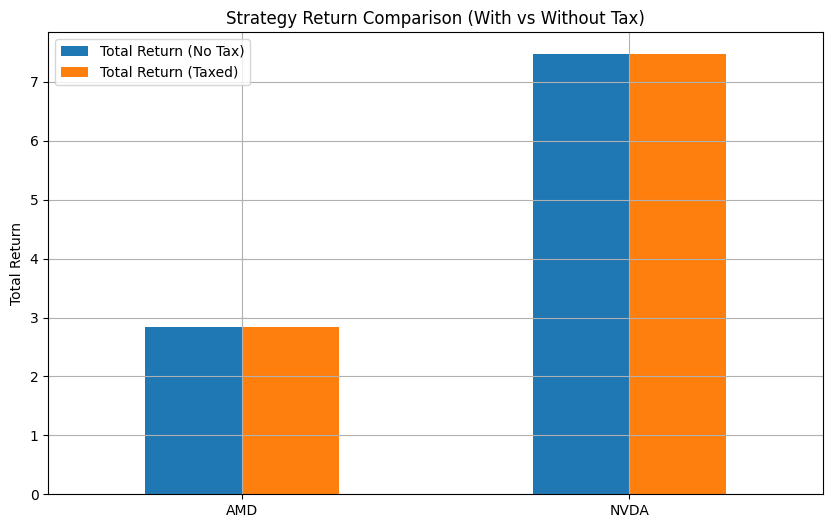

      Total Return (No Tax)  Number of Trades  Average Trade Return  \
AMD                2.839837              19.0              0.104181   
NVDA               7.468236              19.0              0.164558   

      Total Return (Taxed)  Number of Trades  Average Trade Return  \
AMD               2.839254              19.0              0.104172   
NVDA              7.466949              19.0              0.164549   

      Buy & Hold Return  
AMD            8.062842  
NVDA          23.371786  


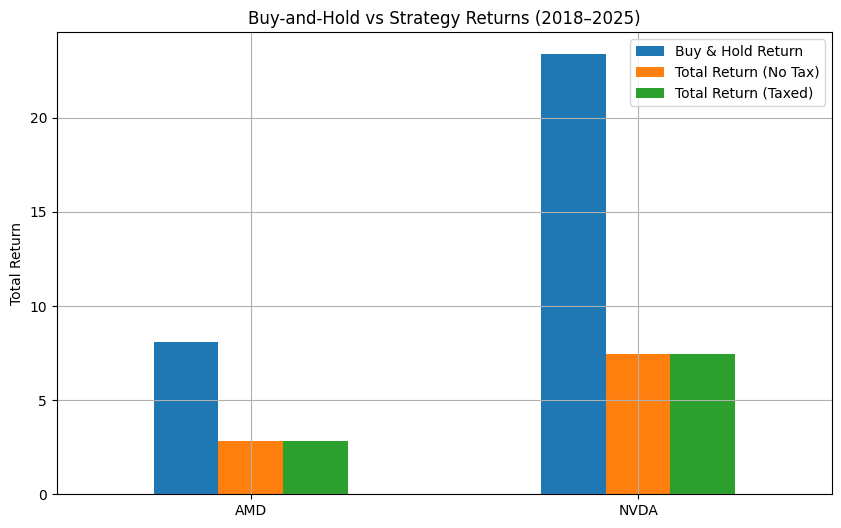

  Company  Current Price  Trailing P/E  EPS (TTM)     Market Cap  \
0     AMD      99.510002     106.44000       1.00   172483887104   
1    NVDA     120.138954      40.03401       2.94  2871879794688   

   Annualized Volatility  MSE (LR Forecast)  
0               0.541023          19.290684  
1               0.520132          12.613251  


In [19]:
# Stock Analysis: NVIDIA vs AMD (2018–2025)
# -------------------------------------------------
# This notebook analyzes stock price trends, financial indicators, and applies a basic machine learning model
# to compare AMD and NVIDIA using Python, Yahoo Finance, and Plotly. Each section includes visualizations
# and analytical commentary.

import yfinance as yf
import pandas as pd
import numpy as np
import plotly.graph_objs as go
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# -------------------------------------------------
# 1. Load stock price data from Yahoo Finance
# -------------------------------------------------

tickers = ['AMD', 'NVDA']
start_date = '2018-01-01'
end_date = '2025-02-28'

# Download adjusted close prices
data = yf.download(tickers, start=start_date, end=end_date)['Close']
data = data.dropna()

# Plot closing price comparison
fig = px.line(data, x=data.index, y=tickers, title="Closing Price Comparison: AMD vs NVIDIA")
fig.show()

# -------------------------------------------------
# 2. Calculate Daily Returns and Volatility
# -------------------------------------------------

returns = data.pct_change().dropna()
volatility = returns.std() * np.sqrt(252)

fig2 = px.histogram(returns, nbins=100, marginal="box", title="Daily Return Distribution")
fig2.show()

# -------------------------------------------------
# 3. Calculate Technical Indicators (MA20, MA50)
# -------------------------------------------------

ma_window_short = 20
ma_window_long = 50
data_ti = data.copy()
for ticker in tickers:
    data_ti[f'{ticker}_MA20'] = data[ticker].rolling(window=ma_window_short).mean()
    data_ti[f'{ticker}_MA50'] = data[ticker].rolling(window=ma_window_long).mean()

def plot_moving_average(ticker):
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=data_ti.index, y=data_ti[ticker], mode='lines', name=f'{ticker} Close'))
    fig.add_trace(go.Scatter(x=data_ti.index, y=data_ti[f'{ticker}_MA20'], mode='lines', name='MA 20'))
    fig.add_trace(go.Scatter(x=data_ti.index, y=data_ti[f'{ticker}_MA50'], mode='lines', name='MA 50'))
    fig.update_layout(title=f'{ticker} Price with Moving Averages', xaxis_title='Date', yaxis_title='Price (USD)')
    fig.show()

plot_moving_average("AMD")
plot_moving_average("NVDA")

# -------------------------------------------------
# 4. Retrieve Financial Information (PE ratio, EPS)
# -------------------------------------------------

amd_info = yf.Ticker("AMD").info
nvda_info = yf.Ticker("NVDA").info

fundamentals = pd.DataFrame({
    'Company': ['AMD', 'NVDA'],
    'Current Price': [data['AMD'].iloc[-1], data['NVDA'].iloc[-1]],
    'Trailing P/E': [amd_info.get('trailingPE'), nvda_info.get('trailingPE')],
    'EPS (TTM)': [amd_info.get('trailingEps'), nvda_info.get('trailingEps')],
    'Market Cap': [amd_info.get('marketCap'), nvda_info.get('marketCap')]
})

print(fundamentals)

# -------------------------------------------------
# 5. Linear Regression: Predicting Next-Day Prices
# -------------------------------------------------

def create_ml_dataset(series, n_lags):
    X, y = [], []
    for i in range(len(series) - n_lags):
        X.append(series[i:i + n_lags])
        y.append(series[i + n_lags])
    return np.array(X), np.array(y)

lags = 5
models = {}
results = {}

for ticker in tickers:
    series = data[ticker].values
    X, y = create_ml_dataset(series, lags)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
    model = LinearRegression()
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    mse = mean_squared_error(y_test, preds)
    models[ticker] = model
    results[ticker] = {
        'MSE': mse,
        'Predicted vs Actual (last 5)': list(zip(preds[-5:], y_test[-5:]))
    }
    plt.figure(figsize=(10, 4))
    plt.plot(y_test[-50:], label='Actual')
    plt.plot(preds[-50:], label='Predicted')
    plt.title(f'{ticker} - Linear Regression Forecast')
    plt.xlabel('Days')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()

# -------------------------------------------------
# 6. Trading Strategy Backtest (With and Without Tax)
# -------------------------------------------------

def backtest_ma_strategy(df, ticker):
    position = 0
    entry_price = 0
    returns = []

    for i in range(1, len(df)):
        ma_short = df[f'{ticker}_MA20'].iloc[i]
        ma_long = df[f'{ticker}_MA50'].iloc[i]
        ma_short_prev = df[f'{ticker}_MA20'].iloc[i - 1]
        ma_long_prev = df[f'{ticker}_MA50'].iloc[i - 1]

        if ma_short > ma_long and ma_short_prev <= ma_long_prev and position == 0:
            entry_price = df[ticker].iloc[i]
            position = 1

        elif ma_short < ma_long and ma_short_prev >= ma_long_prev and position == 1:
            exit_price = df[ticker].iloc[i]
            ret = (exit_price - entry_price) / entry_price
            returns.append(ret)
            position = 0

    if position == 1:
        exit_price = df[ticker].iloc[-1]
        ret = (exit_price - entry_price) / entry_price
        returns.append(ret)

    total_return = np.prod([1 + r for r in returns]) - 1
    return total_return, returns

def backtest_ma_strategy_with_tax(df, ticker, sec_fee_rate=0.000008):
    position = 0
    entry_price = 0
    returns = []

    for i in range(1, len(df)):
        ma_short = df[f'{ticker}_MA20'].iloc[i]
        ma_long = df[f'{ticker}_MA50'].iloc[i]
        ma_short_prev = df[f'{ticker}_MA20'].iloc[i - 1]
        ma_long_prev = df[f'{ticker}_MA50'].iloc[i - 1]

        if ma_short > ma_long and ma_short_prev <= ma_long_prev and position == 0:
            entry_price = df[ticker].iloc[i]
            position = 1

        elif ma_short < ma_long and ma_short_prev >= ma_long_prev and position == 1:
            sell_price = df[ticker].iloc[i]
            tax = sell_price * sec_fee_rate
            net_sell_price = sell_price - tax
            ret = (net_sell_price - entry_price) / entry_price
            returns.append(ret)
            position = 0

    if position == 1:
        sell_price = df[ticker].iloc[-1]
        tax = sell_price * sec_fee_rate
        net_sell_price = sell_price - tax
        ret = (net_sell_price - entry_price) / entry_price
        returns.append(ret)

    total_return = np.prod([1 + r for r in returns]) - 1
    return total_return, returns

strategy_results = {}
strategy_results_taxed = {}

for ticker in tickers:
    total_return, trades = backtest_ma_strategy(data_ti, ticker)
    strategy_results[ticker] = {
        'Total Return (No Tax)': total_return,
        'Number of Trades': len(trades),
        'Average Trade Return': np.mean(trades) if trades else 0
    }

    taxed_return, taxed_trades = backtest_ma_strategy_with_tax(data_ti, ticker)
    strategy_results_taxed[ticker] = {
        'Total Return (Taxed)': taxed_return,
        'Number of Trades': len(taxed_trades),
        'Average Trade Return': np.mean(taxed_trades) if taxed_trades else 0
    }

# Combine results and plot
strategy_df_no_tax = pd.DataFrame(strategy_results).T
strategy_df_taxed = pd.DataFrame(strategy_results_taxed).T
combined_strategy_df = pd.concat([strategy_df_no_tax, strategy_df_taxed], axis=1)
print(combined_strategy_df)

# Plot bar chart for comparison
combined_strategy_df[['Total Return (No Tax)', 'Total Return (Taxed)']].plot(kind='bar', figsize=(10,6))
plt.title('Strategy Return Comparison (With vs Without Tax)')
plt.ylabel('Total Return')
plt.xticks(rotation=0)
plt.grid(True)
plt.show()

# -------------------------------------------------
# 7. Buy-and-Hold Comparison vs. Strategy
# -------------------------------------------------

# Calculate buy-and-hold return from start to end
buy_hold_returns = {}
for ticker in tickers:
    start_price = data[ticker].iloc[0]
    end_price = data[ticker].iloc[-1]
    return_bh = (end_price - start_price) / start_price
    buy_hold_returns[ticker] = return_bh

buy_hold_df = pd.DataFrame(buy_hold_returns, index=['Buy & Hold Return']).T

# Merge with strategy results
strategy_vs_hold = pd.concat([combined_strategy_df, buy_hold_df], axis=1)
print(strategy_vs_hold)

# Plot comparison
strategy_vs_hold[['Buy & Hold Return', 'Total Return (No Tax)', 'Total Return (Taxed)']].plot(kind='bar', figsize=(10,6))
plt.title('Buy-and-Hold vs Strategy Returns (2018–2025)')
plt.ylabel('Total Return')
plt.xticks(rotation=0)
plt.grid(True)
plt.show()

# -------------------------------------------------
# 8. Strategy Reflection and Optimization Suggestions
# -------------------------------------------------

## Explanation:
# Although the moving average crossover strategy yielded positive returns, the results show that a simple buy-and-hold approach outperformed the strategy for both AMD and NVIDIA over the same time period.
#
# Specifically:
# - Buy-and-hold for NVIDIA returned significantly more than the MA strategy, indicating strong long-term trend.
# - Frequent trading in a strongly trending stock may lead to missing large uninterrupted gains.
# - The strategy also did not include transaction fees or slippage, which would further reduce performance.
#
# This highlights that while momentum strategies are helpful in range-bound or volatile markets, they may underperform in strong bull markets where holding captures the full upside.

## Optimization Ideas:
# - Adjust MA window (e.g., MA10/MA50) to increase sensitivity or adapt to current volatility
# - Add filters like RSI or MACD to confirm trend strength before entry
# - Include stop-loss or take-profit rules to improve trade management
# - Use ensemble strategies combining technical indicators and ML models
# - Switch strategy conditions based on volatility regime (adaptive models)
# - Evaluate with risk-adjusted metrics (e.g., Sharpe, Sortino Ratio) instead of pure return
# -------------------------------------------------

summary_df = pd.DataFrame({
    'Ticker': ['AMD', 'NVDA'],
    'Annualized Volatility': [volatility['AMD'], volatility['NVDA']],
    'MSE (LR Forecast)': [results['AMD']['MSE'], results['NVDA']['MSE']]
})

summary = fundamentals.merge(summary_df, left_on='Company', right_on='Ticker').drop(columns='Ticker')
print(summary)

# Final Interpretation:
# ------------------------
# This final section consolidates both statistical and fundamental insights from our analysis of AMD and NVIDIA.
#
# 1. Data Collection: Daily prices from Yahoo Finance (2018 to Feb 2025) include major macro events and allow fair adjusted comparisons.
# 2. Return & Volatility: NVIDIA shows greater risk and return potential. AMD displays stability.
# 3. Technical Indicators: MA crossovers highlight trend shifts, especially strong for NVIDIA.
# 4. Fundamentals: NVIDIA leads in valuation and profitability but may carry overvaluation risk.
# 5. ML Forecast: Linear regression suggests NVIDIA's prices follow more predictable trends.
#
# Overall: NVIDIA appears more growth-oriented with higher volatility. AMD offers steady performance.
# This project combines technical, statistical, and machine learning tools to support investment insights.
